In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
# Download the Dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

--2024-01-28 10:42:43--  https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.12.27, 142.250.65.123, 172.217.164.27, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.12.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/csv]
Saving to: ‘Sunspots.csv’

Sunspots.csv        100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2024-01-28 10:42:43 (81.4 MB/s) - ‘Sunspots.csv’ saved [70827/70827]



In [3]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    # Check if there are more than two series to plot
    if type(y) is tuple:
      # Loop over the y elements
      for y_curr in y:
        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)
    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)
    # Label the x-axis
    plt.xlabel(xlabel)
    # Label the y-axis
    plt.ylabel(ylabel)
    # Set the legend
    if legend:
      plt.legend(legend)
    # Set the title
    plt.title(title)
    # Overlay a grid on the graph
    plt.grid(True)
    # Draw the graph on screen
    plt.show()

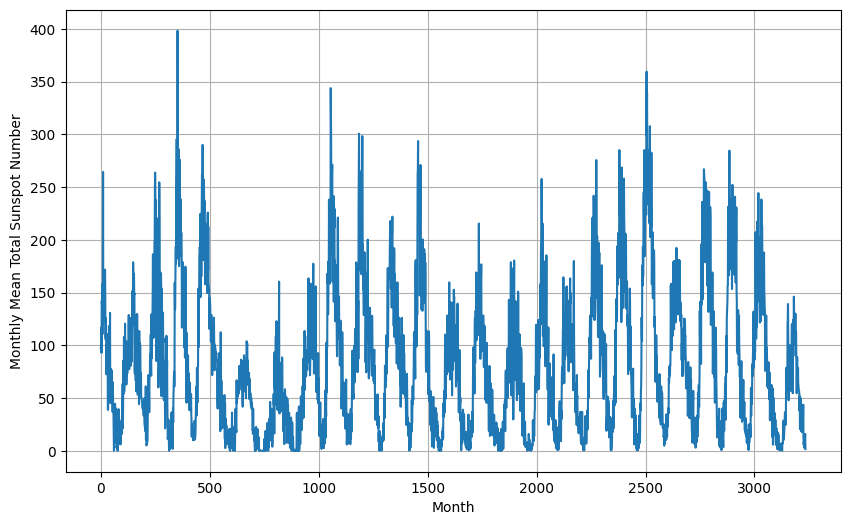

In [4]:
# Initialize lists
time_step = []
sunspots = []
# Open CSV file
with open('./Sunspots.csv') as csvfile:
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  # Skip the first line
  next(reader)
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))
# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)
# Preview the data
plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

In [5]:
# Define the split time
split_time = 3000
# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]
# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [7]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000
# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [8]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

 # Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 30, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                 0

In [9]:
# Get initial weights
init_weights = model.get_weights()

In [10]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 8s 45ms/step - loss: 93.8337 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 4s 42ms/step - loss: 86.7104 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 6s 64ms/step - loss: 81.6366 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 6s 58ms/step - loss: 76.0290 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 5s 56ms/step - loss: 71.7384 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 5s 55ms/step - loss: 68.9963 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 4s 38ms/step - loss: 66.7474 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 3s 34ms/step - loss: 64.6673 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 4s 45ms/step - loss: 62.7073 - lr: 2.5119e-08
Epoch 10/100
93/93 [==============================] - 3s 34ms/step - loss: 60.8290 - lr: 2.8184e-08
Epoch 11/

(1e-08, 0.001, 0.0, 100.0)

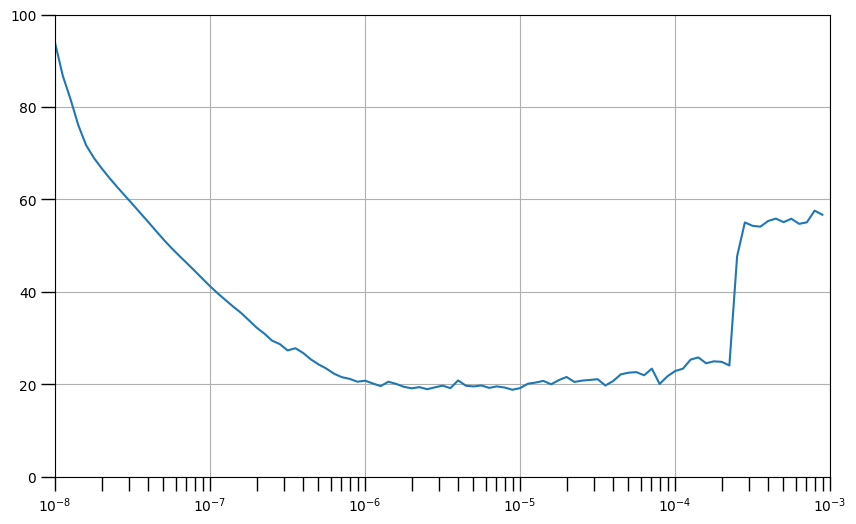

In [11]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

In [14]:
# Reset states generated by Keras
tf.keras.backend.clear_session()
# Reset the weights
model.set_weights(init_weights)

In [18]:
# Set the learning rate
learning_rate = 9e-6

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [19]:
# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
93/93 [==============================] - 7s 34ms/step - loss: 39.8917 - mae: 40.3887
Epoch 2/100
93/93 [==============================] - 4s 45ms/step - loss: 23.9193 - mae: 24.4129
Epoch 3/100
93/93 [==============================] - 3s 34ms/step - loss: 22.5702 - mae: 23.0625
Epoch 4/100
93/93 [==============================] - 3s 34ms/step - loss: 21.8328 - mae: 22.3257
Epoch 5/100
93/93 [==============================] - 4s 41ms/step - loss: 20.7880 - mae: 21.2813
Epoch 6/100
93/93 [==============================] - 4s 35ms/step - loss: 19.8398 - mae: 20.3313
Epoch 7/100
93/93 [==============================] - 3s 34ms/step - loss: 21.2947 - mae: 21.7871
Epoch 8/100
93/93 [==============================] - 4s 44ms/step - loss: 19.2588 - mae: 19.7502
Epoch 9/100
93/93 [==============================] - 3s 34ms/step - loss: 19.3982 - mae: 19.8912
Epoch 10/100
93/93 [==============================] - 3s 34ms/step - loss: 18.4476 - mae: 18.9395
Epoch 11/100
93/93 [=========

In [20]:
def model_forecast(model, series, window_size, batch_size):
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    return forecast

8/8 [==============================] - 1s 14ms/step


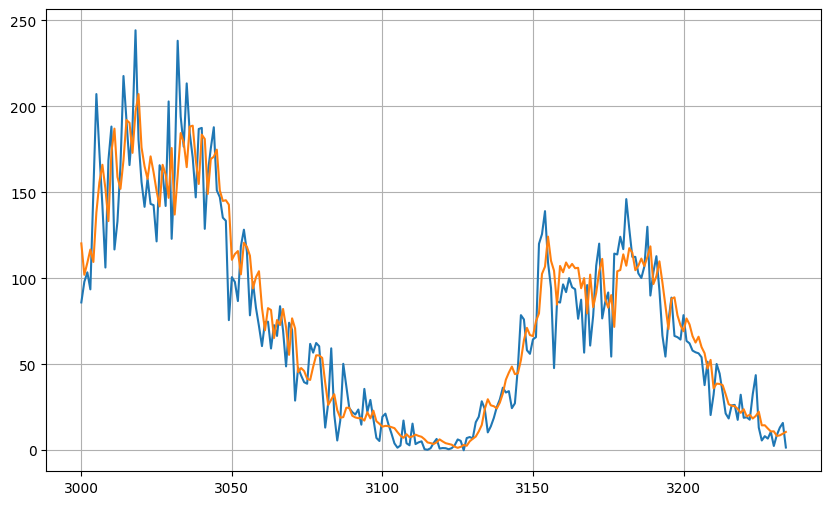

In [21]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]
# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)
# Drop single dimensional axis
results = forecast.squeeze()
# Plot the results
plot_series(time_valid, (x_valid, results))

In [22]:
# Compute the MAE
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

14.599307